In [1]:
import os
import warnings
warnings.simplefilter(action='ignore') # , category=FutureWarning)

from matplotlib import pyplot as plt
import matplotlib.colors as colors
import matplotlib

import numpy as np
import xarray as xr
import pandas as pd
from xgcm import Grid
import dask
import dask.array as da

import itertools

from collections import OrderedDict

import gridop as gop
import diags as dg
import plot as cplt
from model import Model
from tools import wait_cluster_ready

# fig_size = plt.rcParams["figure.figsize"]
# fig_size[0] = 10
# fig_size[1] = 8
# plt.rcParams["figure.figsize"] = fig_size

### Launch dask cluster

In [2]:
from dask.distributed import Client, LocalCluster

# number of cores per node
workers_per_job = 4
# number of nodes
jobs = 2
nworkers = workers_per_job * jobs

# type of cluster
config = 1

if config==1:
    # pour 1 seul noeud
    cluster = LocalCluster(n_workers=2, threads_per_worker=2)
    client = Client(cluster)
else:
    # pour plusieurs noeuds:
    # ** processes and cores may be adjusted in order to have more memory 
    # or inversely more computational ressource
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster(processes=workers_per_job, cores=workers_per_job, walltime='02:00:00')
    w = cluster.scale(jobs=jobs)
    #cluster.adapt(minimum=1, maximum=5)

    client = Client(cluster)
    wait_cluster_ready(cluster, nworkers)
    
# put tmp files of dask in the scratch directory
try:
    scratch = os.environ['SCRATCH']
except:
    scratch = os.environ['HOME']
dask.config.set(local_directory=scratch)

client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/slgentil/proxy/8787/status,
Dashboard: /user/slgentil/proxy/8787/status,Workers: 2
Total threads: 4,Total memory: 115.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:57104,Workers: 2
Dashboard: /user/slgentil/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 115.00 GiB
Comm: tcp://127.0.0.1:59742,Total threads: 2
Dashboard: /user/slgentil/proxy/48124/status,Memory: 57.50 GiB
Nanny: tcp://127.0.0.1:33967,


---
### Parameters

In [3]:
# Initialisation gigatl3
# path = '/home/datawork-lops-megatl/GIGATL3/GIGATL3_1h/HIS/'
# filenames = [path+'GIGATL3_12h_inst_2012-07-16-2012-07-20.nc']
# gridname  = '/home/datawork-lops-megatl/GIGATL3/gigatl3_grid.nc'

# Initialisation gigatl6
path = '/home/datawork-lops-megatl/GIGATL6/GIGATL6_1h_UP5/HIS/'
filenames = [path+'GIGATL6_12h_inst_2012-07-16-2012-07-20.nc']
gridname  = '/home/datawork-lops-megatl/GIGATL6/gigatl6_grd.nc'
suffix=''
longitude = -35.
latitude = 10.
depth = -100.
# deltat = None
seldate = '2012-07-16'

--- 
### Create an instance of the Model class 
which contains all the substitutions of the variables names depending on the model: 
- croco_xios

In [4]:
croco = Model("croco_xios")

### Open all the data files and the grid file and return a dataset. Create the xgcm grid.

In [5]:
%%time
drop_variables = ['time', 'nav_lon_w', 'nav_lat_w',
                  'sustr', 'svstr','bvf',
                  'hc','h','Vtransform','sc_r','sc_w',
                  'Cs_r','Cs_w','angle','mask_rho',
                  'pm','pn','Tcline','theta_s','theta_b',
                  'lon_rho','lat_rho','lon_u','lat_u','lon_v','lat_v',
                  'nav_lon_rho','nav_lat_rho','nav_lon_u','nav_lat_u','nav_lon_v','nav_lat_v',
                  'time_instant','time_instant_bounds',
                  'time_counter_bounds',
                 ]
ds, grid = gop.open_files(croco, gridname, filenames, grid_metrics=1, 
                          drop_variables=drop_variables, suffix=suffix,
                          chunks={'t':1},
                          # chunks={'t':1, 's':1, 's_w':1},
                         )

CPU times: user 1.33 s, sys: 252 ms, total: 1.58 s
Wall time: 2.37 s


In [6]:
ds

<xarray.Dataset>
Dimensions:      (s_w: 51, s: 50, t: 10, y: 2002, x: 1502, x_u: 1501, y_v: 2001)
Coordinates:
  * s_w          (s_w) float32 -1.0 -0.98 -0.96 -0.94 ... -0.06 -0.04 -0.02 0.0
  * s            (s) float32 -0.99 -0.97 -0.95 -0.93 ... -0.07 -0.05 -0.03 -0.01
  * t            (t) datetime64[ns] 2012-07-16T12:00:00 ... 2012-07-21
    lon          (y, x) float64 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
    lat          (y, x) float64 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
    lon_u        (y, x_u) float64 dask.array<chunksize=(2002, 1501), meta=np.ndarray>
    lat_u        (y, x_u) float64 dask.array<chunksize=(2002, 1501), meta=np.ndarray>
    lon_v        (y_v, x) float64 dask.array<chunksize=(2001, 1502), meta=np.ndarray>
    lat_v        (y_v, x) float64 dask.array<chunksize=(2001, 1502), meta=np.ndarray>
    lon_f        (y_v, x_u) float64 dask.array<chunksize=(2001, 1501), meta=np.ndarray>
    lat_f        (y_v, x_u) float64 dask.array<chunksize=(2001, 1501), meta=np.ndarray>
Dimensions without coordinates: y, x, x_u, y_v
Data variables: (12/33)
    z_sfc        (t, y, x) float32 dask.array<chunksize=(1, 2002, 1502), meta=np.ndarray>
    xcur_btrope  (t, y, x_u) float32 dask.array<chunksize=(1, 2002, 1501), meta=np.ndarray>
    ycur_btrope  (t, y_v, x) float32 dask.array<chunksize=(1, 2001, 1502), meta=np.ndarray>
    xcur         (t, s, y, x_u) float32 dask.array<chunksize=(1, 50, 2002, 1501), meta=np.ndarray>
    ycur         (t, s, y_v, x) float32 dask.array<chunksize=(1, 50, 2001, 1502), meta=np.ndarray>
    zcur         (t, s, y, x) float32 dask.array<chunksize=(1, 50, 2002, 1502), meta=np.ndarray>
    ...           ...
    dx_psi       (y_v, x_u) float64 dask.array<chunksize=(2001, 1501), meta=np.ndarray>
    dy_psi       (y_v, x_u) float64 dask.array<chunksize=(2001, 1501), meta=np.ndarray>
    rAr          (y_v, x_u) float64 dask.array<chunksize=(2001, 1501), meta=np.ndarray>
    rAu          (y_v, x) float64 dask.array<chunksize=(2001, 1502), meta=np.ndarray>
    rAv          (y, x_u) float64 dask.array<chunksize=(2002, 1501), meta=np.ndarray>
    rAf          (y, x) float64 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
Attributes: (12/45)
    name:           ./HIS/GIGATL6_12h_inst
    description:    Created by xios
    Conventions:    CF-1.6
    timeStamp:      2019-Nov-24 15:33:54 GMT
    uuid:           eed93f46-c206-494f-af2a-c221ee85e2fc
    title:          GIGATL6
    ...             ...
    SRCS:           main.F step.F read_inp.F timers_roms.F init_scalars.F ini...
    CPP-options:    REGIONAL GIGATL6 MPI_TIME MPI XIOS XIOS2 OBC_EAST OBC_NOR...
    sc_w:           [-1.   -0.98 -0.96 -0.94 -0.92 -0.9  -0.88 -0.86 -0.84 -0...
    Cs_w:           [-1.00000000e+00 -9.66697847e-01 -9.30497932e-01 -8.91828...
    sc_r:           [-0.99 -0.97 -0.95 -0.93 -0.91 -0.89 -0.87 -0.85 -0.83 -0...
    Cs_r:           [-9.83735238e-01 -9.48934833e-01 -9.11442824e-01 -8.71715...

In [7]:
%%time
# ds1 = ds.isel(t=indxdate)
ds1 = ds.sel(t=seldate, method='nearest')
# ds1 = gop.auto_chunk(ds1, keep_complete_dim='s', wanted_chunk=200)
ds1

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 5.3 ms


<xarray.Dataset>
Dimensions:      (s_w: 51, s: 50, y: 2002, x: 1502, x_u: 1501, y_v: 2001)
Coordinates:
  * s_w          (s_w) float32 -1.0 -0.98 -0.96 -0.94 ... -0.06 -0.04 -0.02 0.0
  * s            (s) float32 -0.99 -0.97 -0.95 -0.93 ... -0.07 -0.05 -0.03 -0.01
    t            datetime64[ns] 2012-07-16T12:00:00
    lon          (y, x) float64 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
    lat          (y, x) float64 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
    lon_u        (y, x_u) float64 dask.array<chunksize=(2002, 1501), meta=np.ndarray>
    lat_u        (y, x_u) float64 dask.array<chunksize=(2002, 1501), meta=np.ndarray>
    lon_v        (y_v, x) float64 dask.array<chunksize=(2001, 1502), meta=np.ndarray>
    lat_v        (y_v, x) float64 dask.array<chunksize=(2001, 1502), meta=np.ndarray>
    lon_f        (y_v, x_u) float64 dask.array<chunksize=(2001, 1501), meta=np.ndarray>
    lat_f        (y_v, x_u) float64 dask.array<chunksize=(2001, 1501), meta=np.ndarray>
Dimensions without coordinates: y, x, x_u, y_v
Data variables: (12/33)
    z_sfc        (y, x) float32 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
    xcur_btrope  (y, x_u) float32 dask.array<chunksize=(2002, 1501), meta=np.ndarray>
    ycur_btrope  (y_v, x) float32 dask.array<chunksize=(2001, 1502), meta=np.ndarray>
    xcur         (s, y, x_u) float32 dask.array<chunksize=(50, 2002, 1501), meta=np.ndarray>
    ycur         (s, y_v, x) float32 dask.array<chunksize=(50, 2001, 1502), meta=np.ndarray>
    zcur         (s, y, x) float32 dask.array<chunksize=(50, 2002, 1502), meta=np.ndarray>
    ...           ...
    dx_psi       (y_v, x_u) float64 dask.array<chunksize=(2001, 1501), meta=np.ndarray>
    dy_psi       (y_v, x_u) float64 dask.array<chunksize=(2001, 1501), meta=np.ndarray>
    rAr          (y_v, x_u) float64 dask.array<chunksize=(2001, 1501), meta=np.ndarray>
    rAu          (y_v, x) float64 dask.array<chunksize=(2001, 1502), meta=np.ndarray>
    rAv          (y, x_u) float64 dask.array<chunksize=(2002, 1501), meta=np.ndarray>
    rAf          (y, x) float64 dask.array<chunksize=(2002, 1502), meta=np.ndarray>
Attributes: (12/45)
    name:           ./HIS/GIGATL6_12h_inst
    description:    Created by xios
    Conventions:    CF-1.6
    timeStamp:      2019-Nov-24 15:33:54 GMT
    uuid:           eed93f46-c206-494f-af2a-c221ee85e2fc
    title:          GIGATL6
    ...             ...
    SRCS:           main.F step.F read_inp.F timers_roms.F init_scalars.F ini...
    CPP-options:    REGIONAL GIGATL6 MPI_TIME MPI XIOS XIOS2 OBC_EAST OBC_NOR...
    sc_w:           [-1.   -0.98 -0.96 -0.94 -0.92 -0.9  -0.88 -0.86 -0.84 -0...
    Cs_w:           [-1.00000000e+00 -9.66697847e-01 -9.30497932e-01 -8.91828...
    sc_r:           [-0.99 -0.97 -0.95 -0.93 -0.91 -0.89 -0.87 -0.85 -0.83 -0...
    Cs_r:           [-9.83735238e-01 -9.48934833e-01 -9.11442824e-01 -8.71715...

### U slice at a constant depth

CPU times: user 988 ms, sys: 372 ms, total: 1.36 s
Wall time: 24.7 s


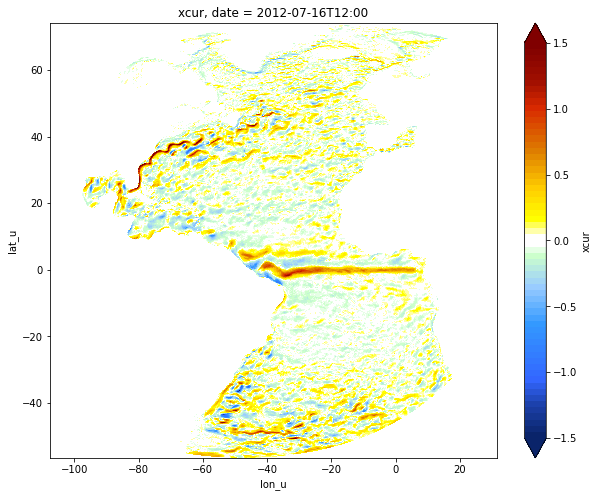

In [8]:
%%time
# depths at u points
z_u = gop.get_z(croco, ds=ds1, z_sfc=ds1.z_sfc, xgrid=grid, hgrid='u')
# slice of u at a constant depth
uslice= gop.slices(croco, ds1.xcur, z_u, ds=ds1, depth=depth)# .compute()
# plot the slice of u
kwargs = {'vmin': -1.5, 'vmax': 1.5, 'extend':'both'}
cplt.plotfig(uslice, **kwargs)

### V slice at a constant depth

CPU times: user 704 ms, sys: 176 ms, total: 880 ms
Wall time: 11.7 s


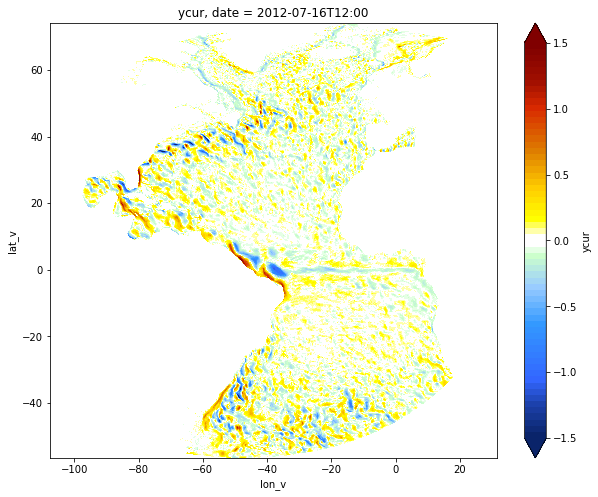

In [9]:
%%time
# depth at v points
z_v = gop.get_z(croco, ds=ds1, z_sfc=ds1.z_sfc, hgrid='v')
# slice of v at a constant depth
# v=ds1.ycur
# v=gop.auto_chunk(v, keep_complete_dim='s', wanted_chunk=200)
vslice= gop.slices(croco, ds1.ycur, z_v, ds=ds1, depth=depth).compute()
# plot the v slice
kwargs = {'vmin': -1.5, 'vmax': 1.5, 'extend':'both'}
cplt.plotfig(vslice, **kwargs)

### Rotate u,v to lat,lon coord

In [10]:
%%time
# depth at rho points
z = gop.get_z(croco, ds=ds1, z_sfc=ds1.z_sfc, xgrid=grid, hgrid='r')
aslice= ds1.angle.compute()
# compute u_EW and v_SN
[urot,vrot] = gop.rotuv(croco, ds1, u=uslice, v=vslice, angle=aslice)

CPU times: user 908 ms, sys: 412 ms, total: 1.32 s
Wall time: 1.57 s


### Compute relative vorticity

CPU times: user 1.23 s, sys: 332 ms, total: 1.56 s
Wall time: 12.6 s


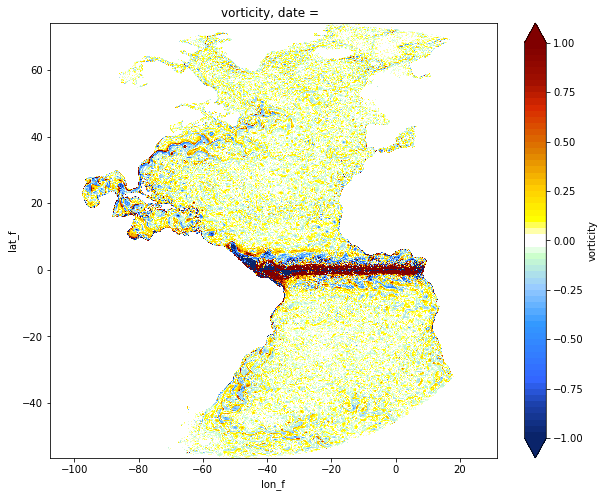

In [11]:
%%time
# compute the relative vorticity at a constant depth
relvort = dg.relative_vorticity(croco, ds=ds1, xgrid=grid, u=uslice, v=vslice)
# plot the relative vorticity
kwargs = {'vmin': -1, 'vmax': 1, 'extend':'both'}
cplt.plotfig(relvort, **kwargs)

### Compute dtemp/dz on a longitudinal slice

CPU times: user 248 ms, sys: 80 ms, total: 328 ms
Wall time: 7.54 s


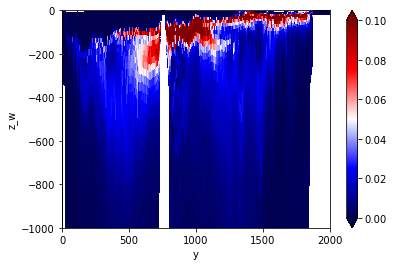

In [12]:
%%time
# longitudinal slice of temperature
tslice = gop.slices(croco, ds1.temp, z, ds=ds1, longitude=longitude).compute()
# compute dtemp/dz
dtdz = dg.dtempdz(croco, ds=ds1, temp=tslice, z=tslice.z)
# plot dtemp/dz
coords = gop.get_spatial_coords(dtdz)
dtdz.plot(x=coords['lat'], y=coords['z'], ylim=[-1000,0], vmin=0, vmax=0.1, cmap="seismic")

### Compute Richardson on a longitudinal slice

9.81
CPU times: user 668 ms, sys: 188 ms, total: 856 ms
Wall time: 23.5 s


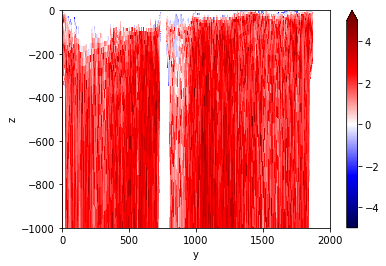

In [13]:
%%time
# longitudinal slices of rho,u,v
rslice = gop.slices(croco, ds1.rho, z, ds=ds1, longitude=longitude).compute()
uslice = gop.slices(croco, ds1.xcur, z_u, ds=ds1, longitude=longitude).compute()
vslice = gop.slices(croco, ds1.ycur, z_v, ds=ds1, longitude=longitude).compute()
# compute the Richardson number
Ri = dg.richardson(croco, ds=ds1, u=uslice, v=vslice, rho=rslice, z=rslice.z)
# plot the Richardson number
coords = gop.get_spatial_coords(Ri)
Ri.plot(x=coords['lat'], y=coords['z'], ylim=[-1000,0], vmin=-5, vmax=5, cmap="seismic")

### Compute the Pressure

In [14]:
%%time
# depth at rho points and w points
z = gop.get_z(croco, ds=ds1, z_sfc=ds1.z_sfc, xgrid=grid, hgrid='r', vgrid='r')
z_w = gop.get_z(croco, ds=ds1, z_sfc=ds1.z_sfc, xgrid=grid, hgrid='r', vgrid='w')
# compute the pressure
P = dg.get_p(croco, ds1.rho, z_w, z, ds=ds1)
# plot the pressure
coords = gop.get_spatial_coords(P)
P.isel(y=int(P.y.size/8)).plot(x=coords['lon'], y=coords['z'], cmap="seismic")

NotImplementedError: Cannot chunk along a core dimension for a grid ufunc which has a signature which includes one of the axis positions ['inner', 'outer']

In [22]:
%%time
if False:
    pv = ertel_pv(croco, ds=ds1, typ='ijk')
    pv.isel(s_w=-1).plot(x=coords['lon'], y=coords['lat'], vmin=-4e-3, vmax=4e-3, cmap="seismic")

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


In [25]:
from scipy.sparse import lil_matrix
from pyamg import ruge_stuben_solver, solve       


def streamfunction(model, pv, ds=None, pm=None, pn=None, xgrid=None):
    """
    Compute the stream function from the relative vorticity
    Invert the laplacian to solve the poisson equation Ax=b
    A is the horizontal laplacian, b is the vorticity
    Input:
        - pm : (DataArray) 1/dx metric
        - pn : (DataArray) 1/dy metric
        - pv : (DataArray) relative vorticity
        - verbo : (Boolean) verbose mode
    Output:
        (DataArray) the computed streamfunction 
    """

    if xgrid is None: xgrid=model.xgrid
    if ds is None: ds=model.ds
        
    if pm is None:
        try: 
            pm=ds.pm
        except:
            print("pm not found in the dataset")
            return None
    if pn is None:
        try: 
            pn=ds.pn
        except:
            print("pn not found in the dataset")
            return None
        
    if np.any(np.isnan(pv)): 
        print("Can't inverse the laplacian, non compact domain, pv contains nan values")
        return None

    #######################################################
    #Create matrix A
    #######################################################
    A = poisson_matrix(pm.values,pn.values)

    #######################################################
    #Solve matrix A
    A = A.tocsr()
    #######################################################

    b = -1. * pv.values.flatten() # right hand side
    ml = ruge_stuben_solver(A)                # construct the multigrid hierarchy
    x = ml.solve(b, tol=1e-8)                       # solve Ax=b to a tolerance of 1e-8     

    residual = np.linalg.norm(b-A*x)          # compute norm of residual vector

    chi = xr.DataArray(
        data=x.reshape(pm.shape),
        dims=["y", "x"],
        coords={'lon':pv.lon, 'lat':pv.lat}
        )
    return chi

def poisson_matrix(pm,pn):    
    """
    Initialize the elliptic equation matrix (d_xx + d_yy)
    Input :
        - pm : (ndarray) 1/dx coefficents
        - pn : (ndarray) 1/dy coefficents
    Output:
        return a sparse matrix of the laplacian operator
    """
    # elliptic equation matrix:  d_xx + d_yy
    [nx,ny] = pm.shape
    
    ndim = ny*nx
    i_s  = ny
    js  = 1
    A=lil_matrix((ndim,ndim))
    ############################
    
    for i in range(nx): 
        for j in range(ny): 
                idx = i*ny + j;
                diag = 0.;
                if j>0:
                    dy2i = 0.5*(pn[i,j]+pn[i,j-1])*pn[i,j]
                    A[idx,idx-js] = dy2i;
                    diag -= dy2i;
                if i>0:
                    dx2i = 0.5*(pm[i,j]+pm[i-1,j])*pm[i,j]
                    A[idx,idx-i_s] = dx2i;
                    diag -= dx2i;
                if i<nx-1:
                    dx2i = 0.5*(pm[i,j]+pm[i+1,j])*pm[i,j]
                    A[idx,idx+i_s] = dx2i;
                    diag -= dx2i;
                if j<ny-1:
                    dy2i = 0.5*(pn[i,j]+pn[i,j+1])*pn[i,j]
                    A[idx,idx+js] = dy2i;
                    diag -= dy2i;
                A[idx,idx] = diag
    
    return A

In [26]:
%%time
if False:
    streamfct = streamfunction(croco, relvort, ds=ds1)
    coords = gop.get_spatial_coords(streamfct)
    streamfct.plot(x=coords['lon'], y=coords['lat'], cmap="seismic")

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


In [ ]:
cluster.close()

distributed.scheduler - ERROR - broadcast to tcp://10.148.0.20:35320 failed: OSError: Timed out trying to connect to tcp://10.148.0.20:35320 after 10 s
distributed.core - ERROR - Exception while handling op terminate
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home1/datahome/slgentil/conda-env/xcroco/lib/python3.10/site-packages/distributed/comm/core.py", line 289, in connect
    comm = await asyncio.wait_for(
  File "/home1/datahome/slgentil/conda-env/xcroco/lib/python3.10/asyncio/tasks.py", line 445, in wait_for
    return fut.result()
  File "/home1/datahome/slgentil/conda-env/xcroco/lib/python3.10/site-packages/distributed/comm/tcp.py", line 451, in connect
    convert_stream_closed_error(self, e)
  File "/home1/datahome/slgentil/conda-env/xcroco/lib/python3.10/site-packages/distributed/comm/tcp.py", line 148, in convert_stream_closed_error
    raise CommClo